In [160]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from numba import jit

visual_drift_coef = 1.2
visual_drift_min = 1
memory_drift_coef = 0.7
memory_drift_adaptive_coef = 1/4
visual_drift_adaptive_coef = 1/4

path_figs = "./Figs/"

In [162]:
# import numpy as np
# import matplotlib.pyplot as plt
# import sklearn
# from numba import jit

# visual_drift_coef = 1.2
# visual_drift_min = 1
# memory_drift_coef = 0.7
# memory_drift_adaptive_coef = 1/4
# visual_drift_adaptive_coef = 1/4

I can add visual delay later to account for bigger RT at the beginning

Important: Check for memory drift adding after a press or after the visual delay for the next press

In [163]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [164]:
def calc_visual_drifts(seq, seq_length):
    seq_fingers = np.array([int(_) for _ in seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result



In [165]:
def calc_memory_drifts(specific_seq, seq_length):
    seq_fingers = np.array([int(_) for _ in specific_seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result

In [166]:
seq = '13524232514'
specific_seq = '13524232514'
random_seq = '45341323141'
specific_seq_changed = '13524313333'
specific_seq_changed_one_digit = '13524212514'
# specific_seq_changed_one_digit = '13524232314'



seq_length = len(seq)

window_sizes = [1,2,3,4,11]

visual_drifts = calc_visual_drifts(seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

# drifts = np.array([1,1,1,1,2]).reshape(5, 1)
# drifts = np.repeat(drifts, seq_length , axis = 1)

visual_delay = 150

diffusion = 2
threshold = 300
alpha = 0.999
beta = 0.001


In [167]:
visual_drifts

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [168]:
memory_drifts

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [169]:
@jit(nopython=True)
def get_planning_coefs(strategy, capacity, param):
    if strategy == 0:
        return exp_normalized_planning_jit(capacity, param)
    elif strategy == 1:
        return inv_normalized_planning_jit(capacity)
    else:
        raise ValueError("Unknown strategy")

@jit(nopython=True)
def exp_normalized_planning_jit(capacity, param):
    x = np.arange(1, capacity + 1)
    if capacity == 0:
        theta = np.exp(-x * np.log(param))
    if capacity == 1:
        theta = np.exp(-x * np.log(param))
    if capacity == 2:
        theta = np.exp(-x * np.log(2.3))
    
    if capacity == 3:
        theta = np.exp(-x * np.log(2.4))

    if capacity >= 4: 
        theta = np.exp(-x * np.log(2.45))

    # theta /= np.sum(theta)
    
    return theta * 2

@jit(nopython=True)
def inv_normalized_planning_jit(capacity):
    x = np.arange(capacity)
    theta = 1 / (x + 1)
    # theta /= np.sum(theta)
    return theta

In [170]:
sum(exp_normalized_planning_jit(capacity=1 , param = 2))

1.0

In [171]:
exp_normalized_planning_jit(capacity=2, param=2)

array([0.86956522, 0.37807183])

In [172]:
for i in range(4):
    print(exp_normalized_planning_jit(capacity=i , param = 2))
    print(sum(exp_normalized_planning_jit(capacity=i , param = 2)))


[]
0
[1.]
1.0
[0.86956522 0.37807183]
1.2476370510396977
[0.83333333 0.34722222 0.14467593]
1.3252314814814816


In [173]:
for i in range(4):
    print(exp_normalized_planning_jit(capacity=i , param = 2.3))
    print(sum(exp_normalized_planning_jit(capacity=i , param = 2.3)))

[]
0
[0.86956522]
0.8695652173913044
[0.86956522 0.37807183]
1.2476370510396977
[0.83333333 0.34722222 0.14467593]
1.3252314814814816


In [174]:
for i in range(11):
    print(exp_normalized_planning_jit(capacity=i , param = 2.4) )
    print(sum(exp_normalized_planning_jit(capacity=i , param = 2.4)))


[]
0
[0.83333333]
0.8333333333333334
[0.86956522 0.37807183]
1.2476370510396977
[0.83333333 0.34722222 0.14467593]
1.3252314814814816
[0.81632653 0.3331945  0.13599776 0.05550929]
1.3410280771183598
[0.81632653 0.3331945  0.13599776 0.05550929 0.02265685]
1.363684929436065
[0.81632653 0.3331945  0.13599776 0.05550929 0.02265685 0.00924769]
1.372932624259618
[0.81632653 0.3331945  0.13599776 0.05550929 0.02265685 0.00924769
 0.00377457]
1.376707193575354
[0.81632653 0.3331945  0.13599776 0.05550929 0.02265685 0.00924769
 0.00377457 0.00154064]
1.3782478341123892
[8.16326531e-01 3.33194502e-01 1.35997756e-01 5.55092882e-02
 2.26568523e-02 9.24769482e-03 3.77456932e-03 1.54064054e-03
 6.28832872e-04]
1.3788766669846484
[8.16326531e-01 3.33194502e-01 1.35997756e-01 5.55092882e-02
 2.26568523e-02 9.24769482e-03 3.77456932e-03 1.54064054e-03
 6.28832872e-04 2.56666478e-04]
1.3791333334631215


In [175]:
for i in range(11):
    print(exp_normalized_planning_jit(capacity=i , param = 2.45))
    print(sum(exp_normalized_planning_jit(capacity=i , param = 2.45)))


[]
0
[0.81632653]
0.8163265306122448
[0.86956522 0.37807183]
1.2476370510396977
[0.83333333 0.34722222 0.14467593]
1.3252314814814816
[0.81632653 0.3331945  0.13599776 0.05550929]
1.3410280771183598
[0.81632653 0.3331945  0.13599776 0.05550929 0.02265685]
1.363684929436065
[0.81632653 0.3331945  0.13599776 0.05550929 0.02265685 0.00924769]
1.372932624259618
[0.81632653 0.3331945  0.13599776 0.05550929 0.02265685 0.00924769
 0.00377457]
1.376707193575354
[0.81632653 0.3331945  0.13599776 0.05550929 0.02265685 0.00924769
 0.00377457 0.00154064]
1.3782478341123892
[8.16326531e-01 3.33194502e-01 1.35997756e-01 5.55092882e-02
 2.26568523e-02 9.24769482e-03 3.77456932e-03 1.54064054e-03
 6.28832872e-04]
1.3788766669846484
[8.16326531e-01 3.33194502e-01 1.35997756e-01 5.55092882e-02
 2.26568523e-02 9.24769482e-03 3.77456932e-03 1.54064054e-03
 6.28832872e-04 2.56666478e-04]
1.3791333334631215


In [176]:
def exp_normalized_planning(capacity=3, param = 3):
    """
    Exponential decay function for planning

    args: 
        capacity (int): capacity of planning
        param (list/np.array): rate
    """
    x = np.arange(capacity)
    theta = np.exp(-x * np.log(param))
    # theta /= sum(theta)

    return theta


def inv_normalized_planning(capacity=3):
    x = np.arange(capacity)
    theta = 1/(x+1)
    # theta /= sum(theta)

    return theta

In [177]:
def check_evidence_to_seq(evidence, seq):
    for press in range(len(seq)):
        if ~(np.argmax(evidence[:, press]) + 1 == int(seq[press])):
            return False
    return True

In [178]:
def calculate_IPI_from_press_time(press_times):

   return [press_times[0]] + [press_times[i] - press_times[i-1] for i in range(1, len(press_times))]

In [179]:
@jit(nopython=True)
def simulate_ddm(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt, max_time, 
                 seq_length, window_size, planning_capacity, planning_param, planning_strategy, visual_delay, alpha, beta):
    evidence = np.zeros((5, seq_length))
    time = 0
    visual_delay_queue = np.zeros(min(window_size, seq_length, planning_capacity))
    current_press = 0

    current_memory_coef = 0
    current_visual_coef = visual_drift_coef

    effective_planning_capacity = 0
    visible_window_size = 0

    planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    sqrt_dt = np.sqrt(dt)
    drifts_visual_dt = visual_drifts * dt
    drifts_memory_dt = memory_drifts * dt
    diffusion_term = diffusion * sqrt_dt

    total_steps = int(max_time / dt)
    random_terms = np.random.randn(5, seq_length, total_steps)
    random_terms_memory = np.random.rand(5, total_steps)

    t_index = 0

    press_times = np.full(seq_length, np.nan)
    A = np.eye(5) * alpha - np.full((5,5), beta) + np.eye(5) * beta


    while time < max_time - dt:
        time += dt
        visual_delay_queue += dt
        t_index += 1

        evidence[:, current_press: ] = A @ evidence[:, current_press: ]
        evidence[:, current_press:] += diffusion_term * random_terms[:, current_press:, t_index]

        for press in range(current_press, min(current_press + visible_window_size, seq_length, current_press + effective_planning_capacity)):
            # evidence[:, press] += planning_coefs[press - current_press] * drifts_visual_dt[:, press] * current_visual_coef + diffusion_term * random_terms[:, t_index]
            evidence[:, press] += planning_coefs[press - current_press] * drifts_visual_dt[:, press] * current_visual_coef
            
            if press == current_press:
                # if seq[current_press] == specific_seq[current_press]:
                #     # evidence[:, current_press] += drifts_memory_dt[:, current_press] + diffusion_term / 2 * random_terms_memory[:, t_index]
                #     evidence[:, current_press] += drifts_memory_dt[:, current_press] * current_memory_coef
                evidence[:, current_press] += drifts_memory_dt[:, current_press] * current_memory_coef

        evidence[:, current_press: ] = np.maximum(0, evidence[:, current_press: ])
            


        if (evidence[:, current_press:min(current_press + visible_window_size, seq_length, current_press + effective_planning_capacity)] >= threshold).any():
            visible_window_size -= 1
            press_times[current_press] = time
            if seq[current_press] == specific_seq[current_press]:
                current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef
                current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
            else:
                current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef
                current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef
                
            current_press += 1
            visual_delay_queue = np.append(visual_delay_queue, 0)
            effective_planning_capacity = min(visible_window_size, seq_length - current_press, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)

            if current_press == seq_length:
                break

        visual_delay_passed_mask = (visual_delay_queue >= visual_delay)
        pass_count = sum(visual_delay_passed_mask)
        if pass_count > 0:
            visible_window_size += pass_count
            visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
            effective_planning_capacity = min(visible_window_size, seq_length - current_press, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    return press_times, evidence

In [180]:
class DriftDiffusionModel_Optimzied:
    def __init__(self, seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt = 1, max_time = 10000,  #todo: when changing dt, the round(time, 2) should be changed according to the precision of dt
                 seq_length = 11, window_size = 2, planning_capacity = 3, planning_param = 3,  
                 planning_strategy = 0, visual_delay = visual_delay, alpha = 0.995, beta = 0.001): #todo: consider having different diffusions for different fingers (e.g. should we have different one when interference happens?)
        """
        Initialize the Drift-Diffusion Model.

        Parameters:
        drifts (list of float): List of drift rates for each process.
        diffusion (float): Diffusion coefficient (assumed to be the same for all processes).
        threshold (float): Decision threshold.
        dt (float): Time step for the discrete-time simulation.
        max_time (float): Maximum simulation time to prevent infinite loops.
        """
        self.seq_length = seq_length
        self.presses = [None for _ in range(seq_length)]
        self.window_size = window_size
        assert visual_drifts.shape == (5,seq_length), "There must be exactly 5 drift rates."
        self.visual_drifts = visual_drifts 
        self.memory_drifts = memory_drifts
        self.diffusion = diffusion
        self.threshold = threshold
        self.dt = dt
        self.max_time = max_time
        self.planning_strategy = planning_strategy
        self.planning_capacity = planning_capacity
        self.planning_param = planning_param
        self.press_times = [None for _ in range(seq_length)]
        self.visual_delay = visual_delay
        self.seq = seq
        self.specific_seq = specific_seq
        self.alpha = alpha
        self.beta = beta
    

    def simulate(self):
        press_times, evidence = simulate_ddm(self.seq, self.specific_seq, self.visual_drifts, self.memory_drifts,
                                              self.diffusion, self.threshold, self.dt, self.max_time, self.seq_length, 
                                              self.window_size, self.planning_capacity, self.planning_param, 
                                              self.planning_strategy, self.visual_delay, self.alpha, self.beta)
        self.press_times = press_times
        return calculate_IPI_from_press_time(self.press_times), evidence
    


    def plot_IPIs(self):
        plt.plot(range(self.seq_length), calculate_IPI_from_press_time(self.press_times))
        plt.show()
                
    
    
    def plot_simulations(self):
        """
        Plot the evidence accumulation for the specified number of simulations.

        Parameters:
        num_simulations (int): Number of simulations to plot.
        """ 
        
        fig, axs = plt.subplots(self.seq_length, figsize=(15,20))
        evidence = np.zeros((5, self.seq_length))
        evidence_over_time = np.zeros((5, self.seq_length, int(self.max_time/self.dt)))
        time = 0
        t_index = 0
        visual_delay_queue = np.array([0] * min(self.window_size, self.seq_length, self.planning_capacity))
        current_press = 0

        current_memory_coef = 0
        current_visual_coef = visual_drift_coef

        effective_planning_capacity = 0
        planning_coefs = get_planning_coefs(strategy= self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
        visible_window_size = 0

        press_times = np.full(seq_length, np.nan)
        A = np.eye(5) * self.alpha - np.full((5,5), beta) + np.eye(5) * beta

        total_steps = int(self.max_time / self.dt)

        random_terms = np.random.randn(5, seq_length ,total_steps)
        # visual_delay_passed = False

        while time < self.max_time - self.dt:
            time += self.dt
            t_index += 1
            visual_delay_queue += self.dt
            # current_press_time += self.dt


            evidence[:, current_press: ] = A @ evidence[:, current_press: ]
            evidence[:, current_press:] += self.diffusion * np.sqrt(self.dt) * random_terms[:, current_press:, t_index]
            evidence_over_time[:, current_press: ,t_index] = evidence[:, current_press:]

            for press in range(current_press, min(current_press + visible_window_size, self.seq_length,current_press + effective_planning_capacity)):
                for finger in range(5):
                    # evidence[finger, press] += planning_coefs[press - current_press] * self.visual_drifts[finger, press] * self.dt + self.diffusion * np.sqrt(self.dt) * np.random.randn()
                    evidence[finger, press] += planning_coefs[press - current_press] * self.visual_drifts[finger, press] * self.dt * current_visual_coef 
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

                if press == current_press:
                        for finger in range(5):
                            # evidence[finger, current_press] += self.memory_drifts[finger, current_press] * self.dt + self.diffusion / 2 * np.sqrt(self.dt) * np.random.randn()
                            evidence[finger, current_press] += self.memory_drifts[finger, current_press] * self.dt * current_memory_coef
                            evidence_over_time[finger, current_press, t_index] = evidence[finger, current_press]

            for press in range(0, current_press):
                for finger in range(5):
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

            evidence[:, current_press: ] = np.maximum(0, evidence[:, current_press: ])


            if (evidence[: , current_press:min(current_press + visible_window_size, self.seq_length, current_press + effective_planning_capacity)] >= self.threshold).any():
                press_times[current_press] = time
                # visual_delay_passed = False
                visible_window_size -= 1
                
                if self.seq[current_press] == self.specific_seq[current_press]:
                    current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef
                    current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
                else:
                    current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef
                    current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef

                print("current memory: ", current_memory_coef)
                print("current vision: ", current_visual_coef)

                current_press += 1
                visual_delay_queue = np.append(visual_delay_queue, 0)
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy=self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)

                if current_press == self.seq_length:
                    break

            visual_delay_passed_mask = (visual_delay_queue >= self.visual_delay)
            pass_count = sum(visual_delay_passed_mask)
            if pass_count > 0:
                visible_window_size += pass_count
                visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy = self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param) 
            
            # if current_press_time >= self.visual_delay:
            #     if ~visual_delay_passed:
            #         visual_delay_passed = True
            #         visible_window_size = self.window_size
            #         planning_capacity = min(visible_window_size, self.seq_length - current_press, self.planning_capacity)
            #         planning_coefs = self.planning_strategy(capacity = planning_capacity)
                    

        for press in range(self.seq_length):
            for finger in range(5):
                axs[press].plot(np.arange(0, np.round(time, 2), self.dt), evidence_over_time[finger, press, :t_index], label = f'Finger {finger+1}')
            axs[press].set_xlim([0, np.round(time, 2)])
            axs[press].axhline(y = self.threshold, color = 'r', linestyle = '--', label = 'Threshold')
            axs[press].set_xlabel('Time')
            axs[press].axvline(x = press_times[press], color = 'b', linestyle = '--', label = 'hit')
            # axs[press].set_ylabel('Evidence')
            axs[press].set_xticks(np.append(axs[press].get_xticks(), press_times[press]))

            axs[press].set_title(f'Press {press + 1}')

        fig.supylabel('Evidence')

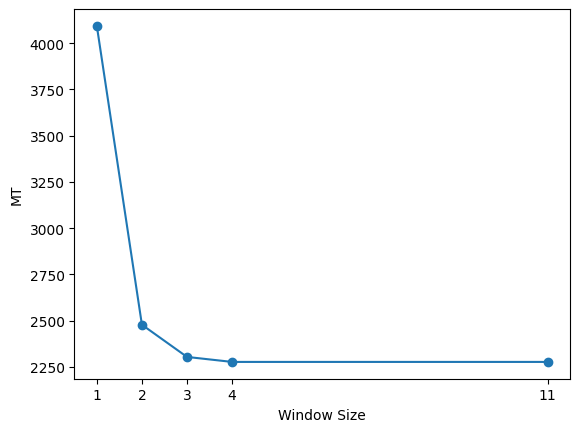

CPU times: user 4.11 s, sys: 66 ms, total: 4.17 s
Wall time: 4.16 s


In [181]:
%%time 
visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
num_sims = 50
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = 0, 
    threshold = threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o')
plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.show()


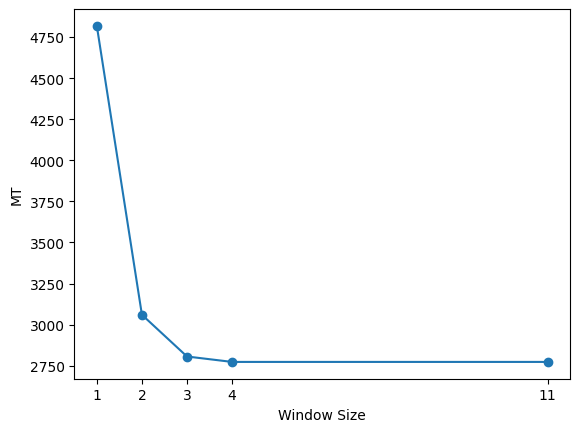

CPU times: user 3.29 s, sys: 66.5 ms, total: 3.36 s
Wall time: 2.87 s


In [143]:
%%time 
visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
num_sims = 50
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0, 
    threshold = threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o')
plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.show()


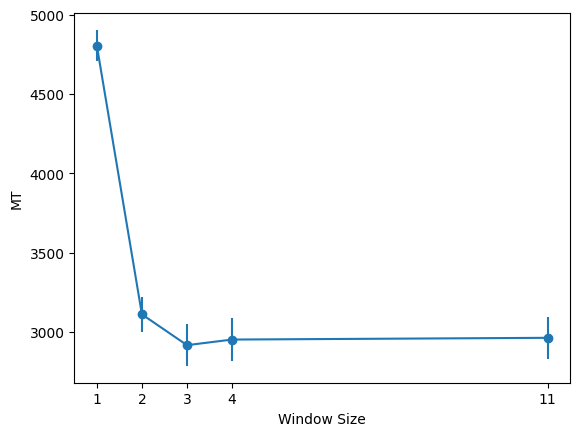

CPU times: user 5.84 s, sys: 95.4 ms, total: 5.94 s
Wall time: 5.49 s


In [144]:
%%time 
visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
num_sims = 100
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = diffusion, 
    threshold = threshold, window_size=window, visual_delay=150, 
    planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o')
plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.show()


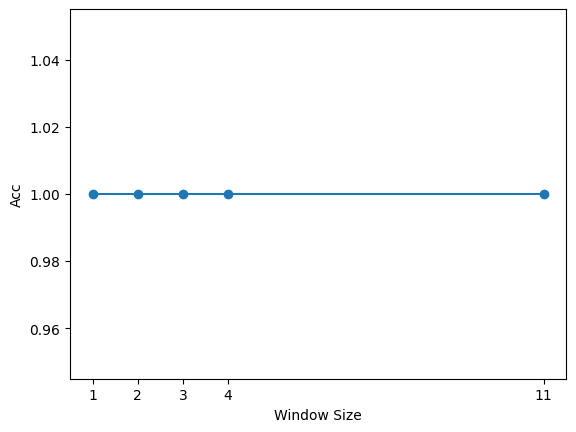

CPU times: user 3.27 s, sys: 56 ms, total: 3.33 s
Wall time: 2.91 s


In [145]:
%%time 
MT = {window: [] for window in window_sizes}
num_sims = 50
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
    diffusion = diffusion, threshold = threshold , window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(check_evidence_to_seq(evidence, random_seq))


#Calculating mean and std for each window size
MT_mean = {window: np.sum(MT_vals) for window, MT_vals in MT.items()}
# MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

# plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o')
plt.errorbar(MT_mean.keys(), np.array(list(MT_mean.values()))/num_sims, fmt='-o')

plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('Acc')
plt.show()


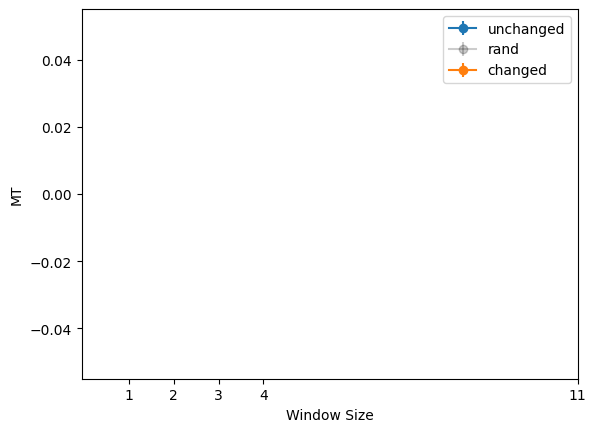

CPU times: user 2min 23s, sys: 1.37 s, total: 2min 24s
Wall time: 2min 24s


In [146]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

MT = {window: [] for window in window_sizes}
num_sims = 500
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, 
    window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = 0.995)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'unchanged', **kwargs['unchanged'])


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

MT = {window: [] for window in window_sizes}
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), diffusion, threshold, window_size=window, 
    visual_delay=150, planning_capacity=4, planning_param=2, alpha = 0.995)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'rand', **kwargs['rand'])


visual_drifts = calc_visual_drifts(specific_seq_changed, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

MT = {window: [] for window in window_sizes}
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed, specific_seq, visual_drifts, memory_drifts, diffusion,
     threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = 0.995)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'changed', **kwargs['changed'])





plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.legend()
plt.show()


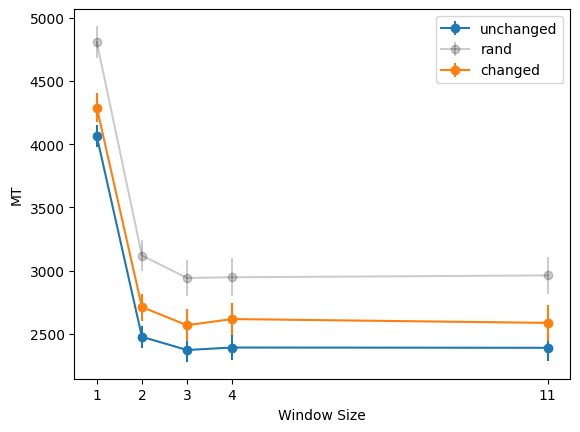

CPU times: user 30.9 s, sys: 491 ms, total: 31.3 s
Wall time: 31 s


In [184]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
num_sims = 200
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha , beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'unchanged', **kwargs['unchanged'])

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

MT = {window: [] for window in window_sizes}
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'rand', **kwargs['rand'])



visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = {window: [] for window in window_sizes}
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, 
    diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o', label = 'changed', **kwargs['changed'])





plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.legend()
plt.show()


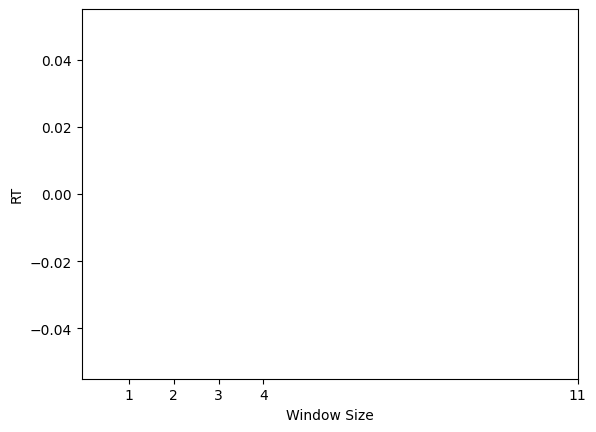

CPU times: user 48.9 s, sys: 560 ms, total: 49.5 s
Wall time: 49.8 s


In [148]:
%%time
RT = {window: [] for window in window_sizes}
num_sims = 500
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('RT')
plt.show()


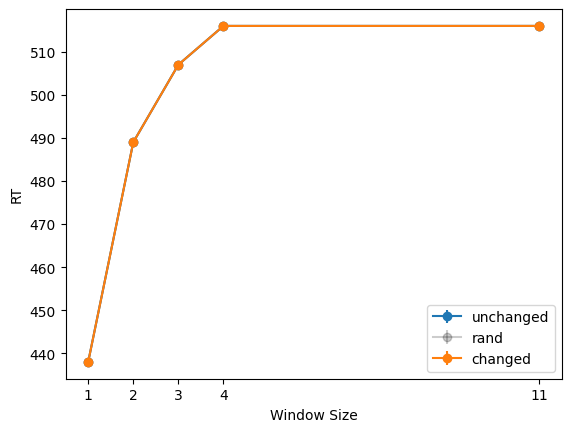

CPU times: user 8.47 s, sys: 188 ms, total: 8.66 s
Wall time: 8.24 s


In [149]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

RT = {window: [] for window in window_sizes}
num_sims = 50
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = 0, threshold = threshold, 
    window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'unchanged', **kwargs['unchanged'])



visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
RT = {window: [] for window in window_sizes}
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0, threshold = threshold, window_size=window, 
    visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'rand', **kwargs['rand'])



visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
RT = {window: [] for window in window_sizes}
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq_changed, visual_drifts, memory_drifts, diffusion = 0, threshold = threshold,
     window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'changed', **kwargs['changed'])






plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('RT')
plt.legend()
plt.show()


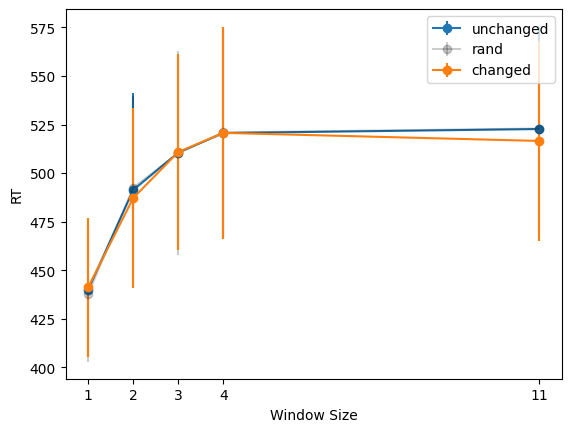

CPU times: user 1min 17s, sys: 1.22 s, total: 1min 18s
Wall time: 1min 19s


In [183]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

RT = {window: [] for window in window_sizes}
num_sims = 500
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, 
    window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'unchanged', **kwargs['unchanged'])

RT = {window: [] for window in window_sizes}
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion, threshold, window_size=window, 
    visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'rand', **kwargs['rand'])


RT = {window: [] for window in window_sizes}
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq_changed, visual_drifts, memory_drifts, diffusion, threshold,
     window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o', label = 'changed', **kwargs['changed'])






plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('RT')
plt.legend()
plt.show()


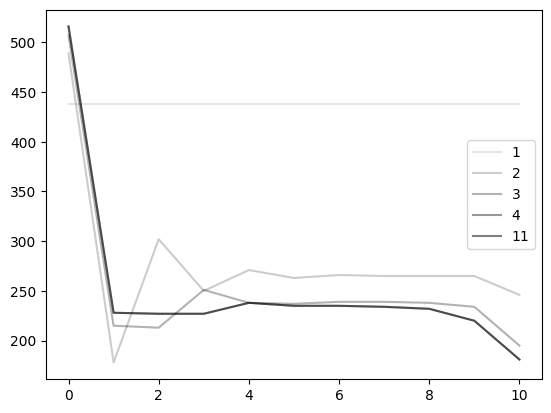

CPU times: user 714 ms, sys: 7.21 ms, total: 722 ms
Wall time: 297 ms


In [151]:
%%time 
num_sims = 1


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
    diffusion = 0, threshold = threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))



plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


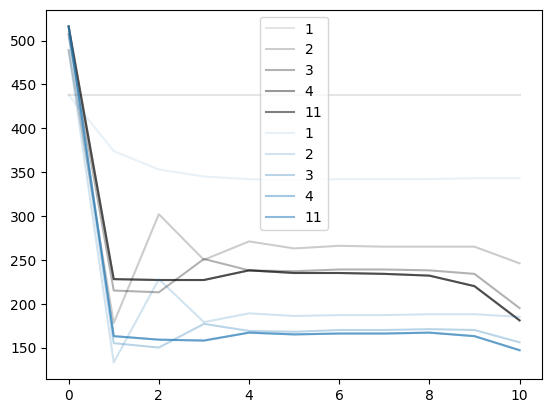

CPU times: user 961 ms, sys: 9.09 ms, total: 970 ms
Wall time: 358 ms


In [152]:
%%time 
kwargs = {'changed': {'color': 'C1', 'alpha': 1}, 'unchanged': {'color': 'C0', 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}
num_sims = 1


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
    diffusion = 0, threshold = threshold, window_size=window, 
    visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))


visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, 
    memory_drifts, diffusion = 0, threshold = threshold, window_size=window, 
    visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C0', alpha = (idx+1)/(2 *len(window_sizes)))

plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


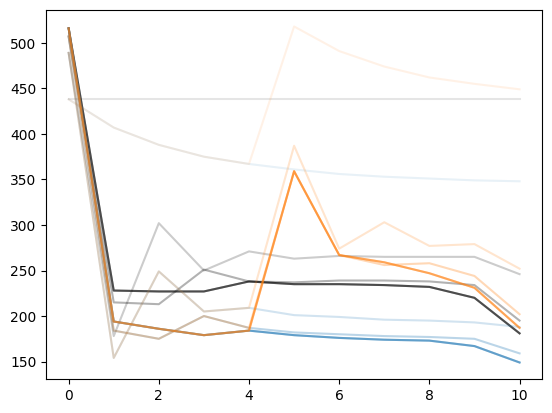

In [185]:

num_sims = 50

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0
                                          , threshold = threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha , beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion = 0, threshold = threshold, window_size=window, 
                                          visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C0', alpha = (idx+1)/(2 *len(window_sizes)))




visual_drifts = calc_visual_drifts(specific_seq_changed, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed, specific_seq, visual_drifts, memory_drifts, diffusion = 0, 
                                          threshold = threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha , beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C1', alpha = (idx+1)/(2 *len(window_sizes)))


# plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


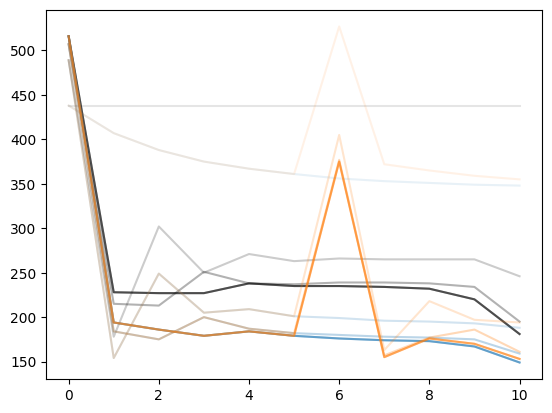

In [186]:

num_sims = 10

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    # model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
    #                                       diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = 0.955)
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, memory_drifts, diffusion= 0, threshold = threshold, 
            window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, diffusion = 0 , threshold= threshold, 
            window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C0', alpha = (idx+1)/(2 *len(window_sizes)))




visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, diffusion = 0, threshold = threshold, 
            window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'C1', alpha = (idx+1)/(2 *len(window_sizes)))


plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


SystemError: CPUDispatcher(<function simulate_ddm at 0x2bd683940>) returned a result with an error set

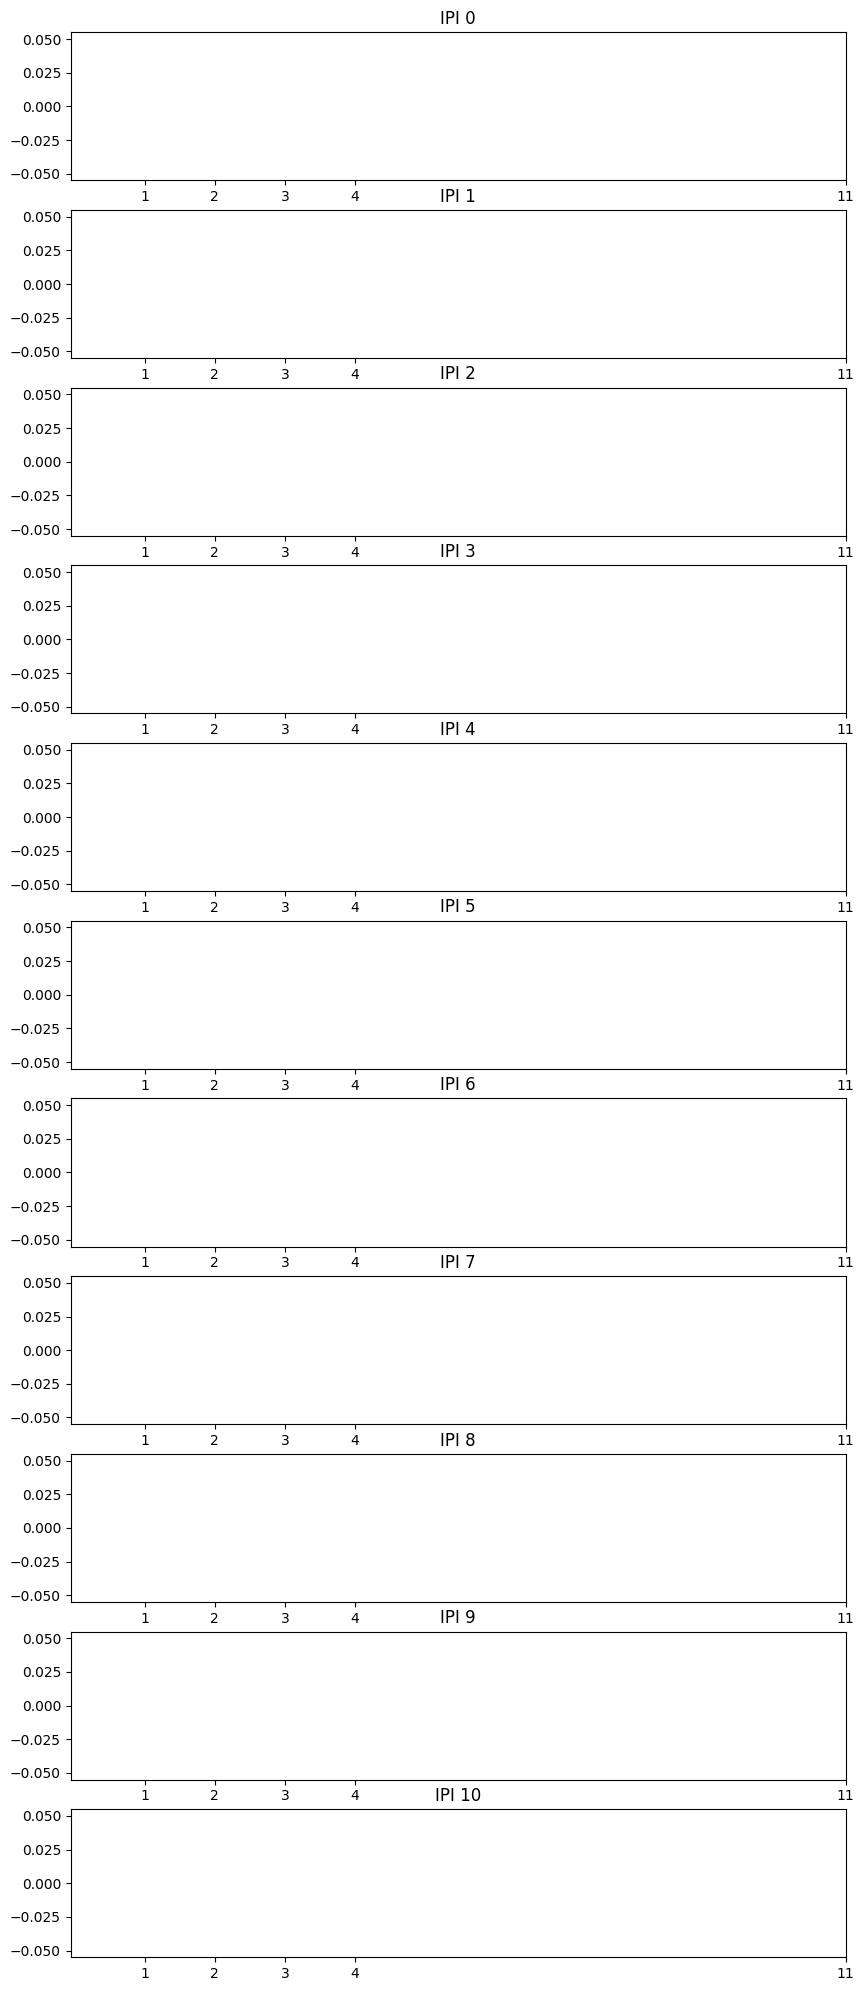

In [155]:
fig, axs = plt.subplots(seq_length, figsize = (10,25))
num_sims = 100


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
                                          diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = 0.995)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'black', alpha = 0.2)
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, 
                                          memory_drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = 0.995)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'C0')
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')


visual_drifts = calc_visual_drifts(specific_seq_changed, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed, specific_seq, visual_drifts, 
                                          memory_drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = 0.995)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'C1')
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')


# plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


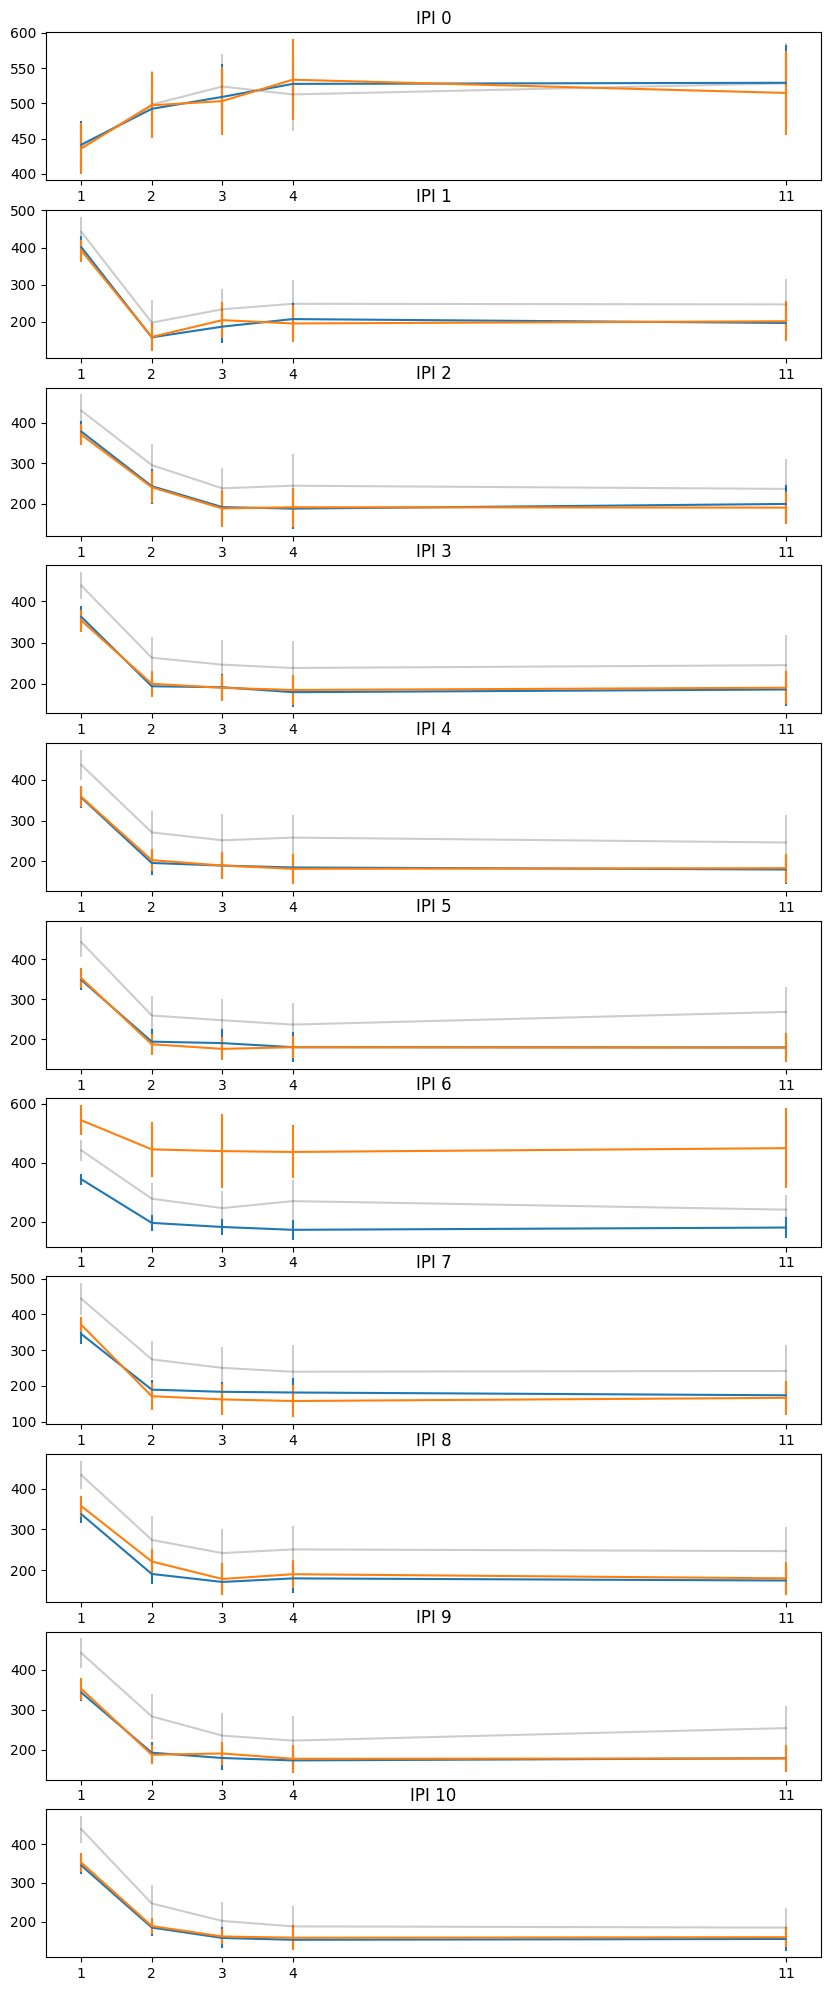

In [86]:
fig, axs = plt.subplots(seq_length, figsize = (10,25))
num_sims = 50


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion, 
                                          threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'black', alpha = 0.2)
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, 
                                          memory_drifts, diffusion, threshold, 
                                          window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'C0')
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')


visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, 
                                          memory_drifts, diffusion, threshold, 
                                          window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha, beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'C1')
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')


# plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


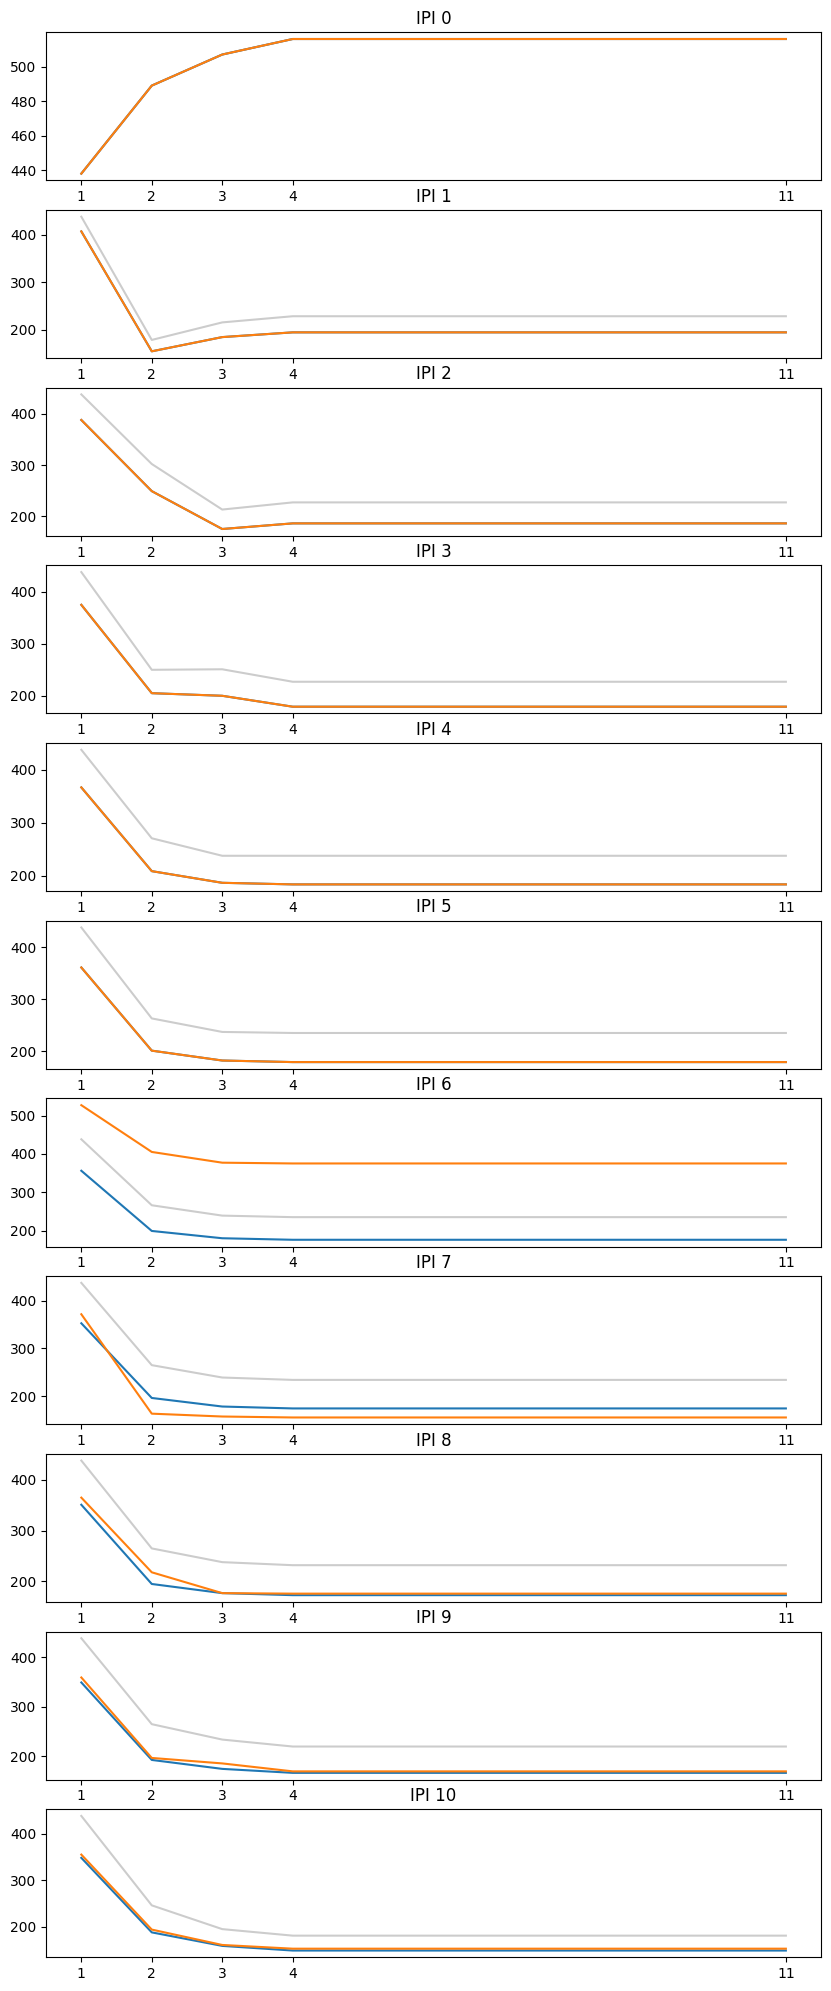

In [187]:
fig, axs = plt.subplots(seq_length, figsize = (10,25))
num_sims = 1


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), diffusion = 0, 
                                          threshold = threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha , beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'black', alpha = 0.2)
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')



visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, 
                                          memory_drifts, diffusion = 0, threshold = threshold, 
                                          window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha , beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'C0')
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')


visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, 
                                          memory_drifts, diffusion = 0, threshold = threshold, 
                                          window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, alpha = alpha , beta = beta)
    for sim in range(num_sims):
        IPIs, evidence = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for press in range(seq_length):
    axs[press].errorbar(IPI.keys(), [ipis[press] for ipis in IPI_mean.values()], yerr = [ipis[press] for ipis in IPI_std.values()], color = 'C1')
    axs[press].set_xticks(list(IPI.keys()))
    axs[press].set_title(f'IPI {press}')


# plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


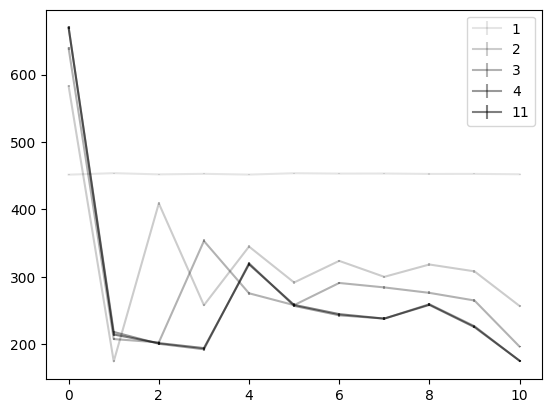

In [ ]:
num_sims = 10000
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2)
    for sim in range(num_sims):
        IPIs = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window], label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    # plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))

IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}


plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


current memory:  0.0
current vision:  1.2
current memory:  0.0
current vision:  1.2
current memory:  0.0
current vision:  1.2
current memory:  0.0
current vision:  1.2
current memory:  0.0
current vision:  1.2
current memory:  0.0
current vision:  1.2
current memory:  0.0
current vision:  1.2
current memory:  0.0
current vision:  1.2
current memory:  0.0
current vision:  1.2
current memory:  0.0
current vision:  1.2
current memory:  0.0
current vision:  1.2


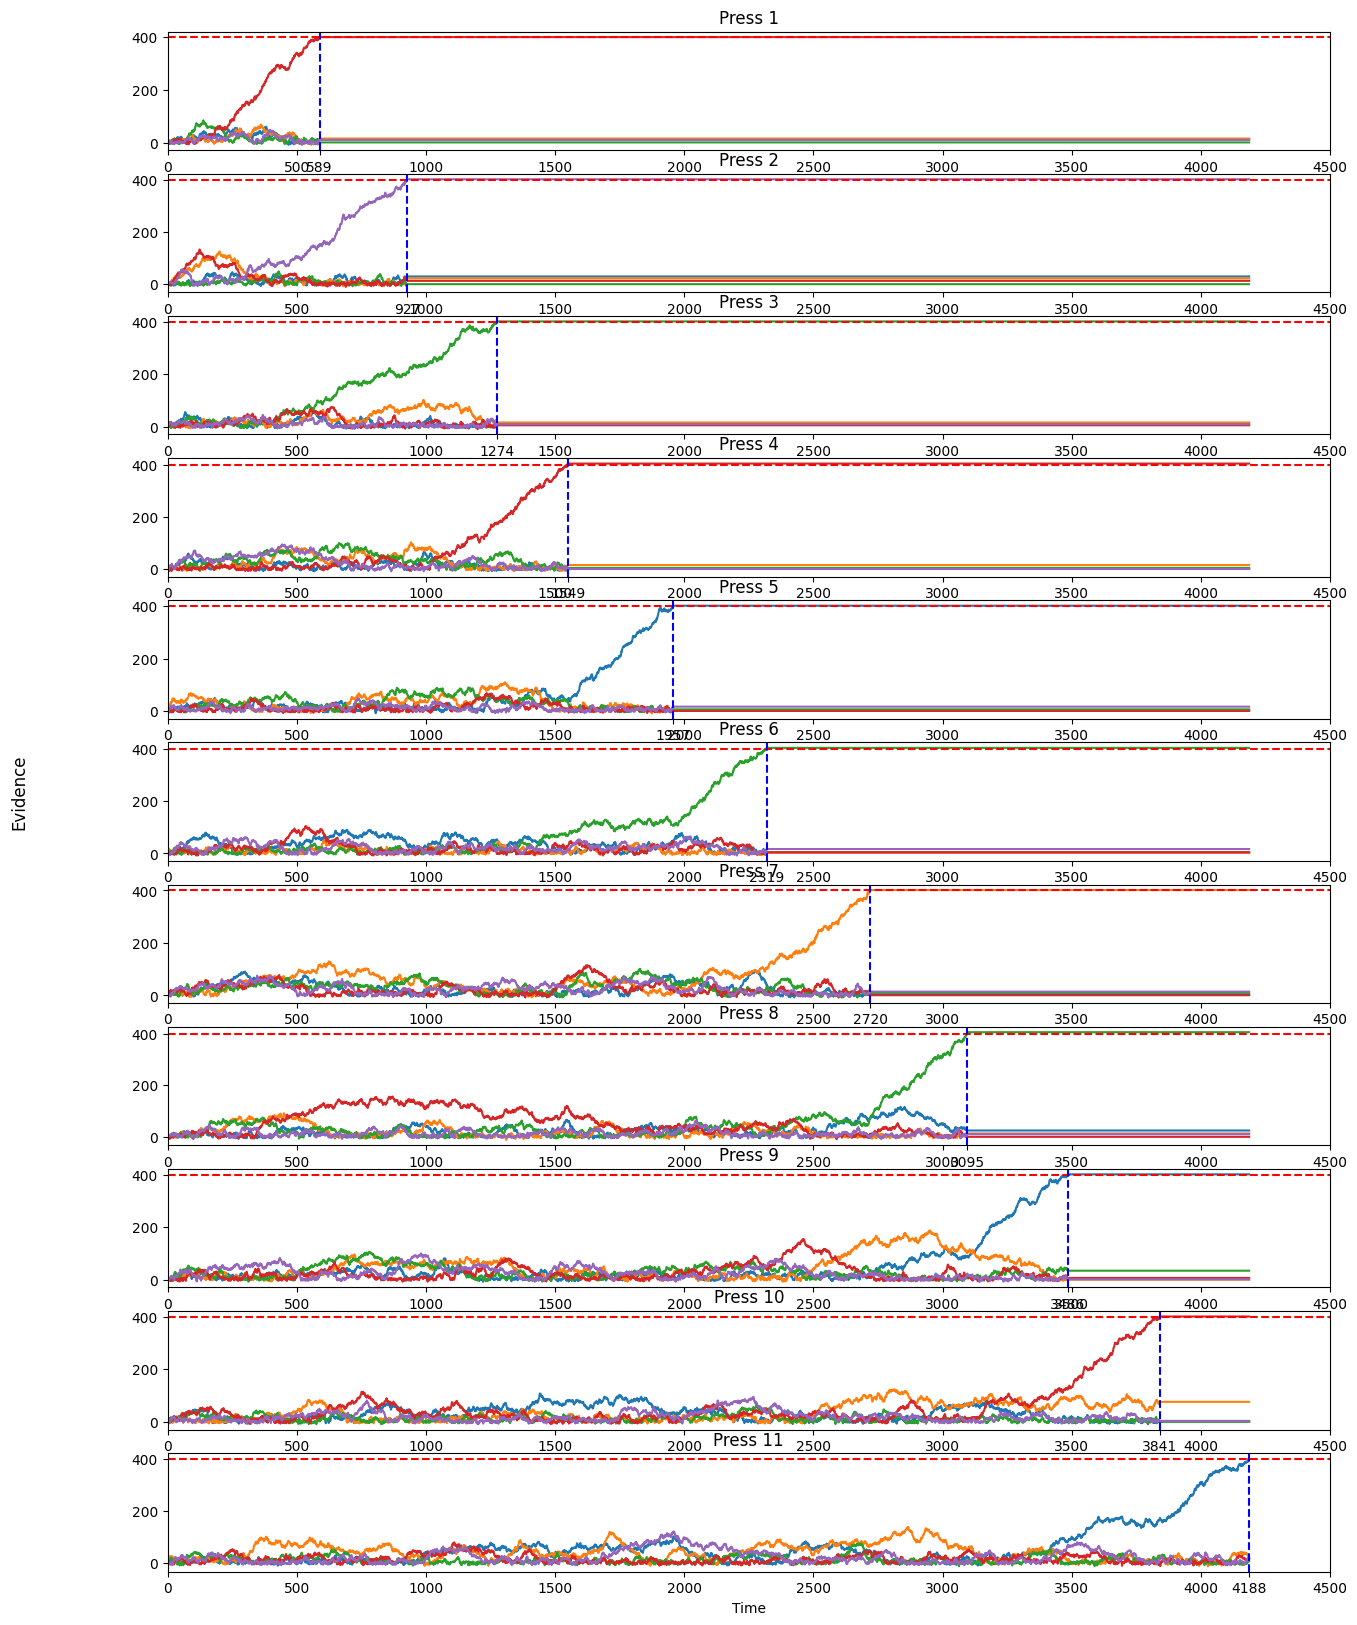

In [ ]:
visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied(random_seq, specific_seq, visual_drifts, np.zeros((5, seq_length)), 
                                      diffusion = diffusion, threshold = threshold, visual_delay=150, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta, window_size=3)
model.plot_simulations()
# model.simulate()
# model.plot_IPIs()

current memory:  0.35
current vision:  1.15
current memory:  0.5249999999999999
current vision:  1.1124999999999998
current memory:  0.6124999999999999
current vision:  1.0843749999999999
current memory:  0.65625
current vision:  1.06328125
current memory:  0.678125
current vision:  1.0474609375
current memory:  0.6890624999999999
current vision:  1.0355957031249998
current memory:  0.34453124999999996
current vision:  1.07669677734375
current memory:  0.522265625
current vision:  1.0575225830078123
current memory:  0.6111328125
current vision:  1.0431419372558592
current memory:  0.65556640625
current vision:  1.0323564529418945
current memory:  0.677783203125
current vision:  1.0242673397064208


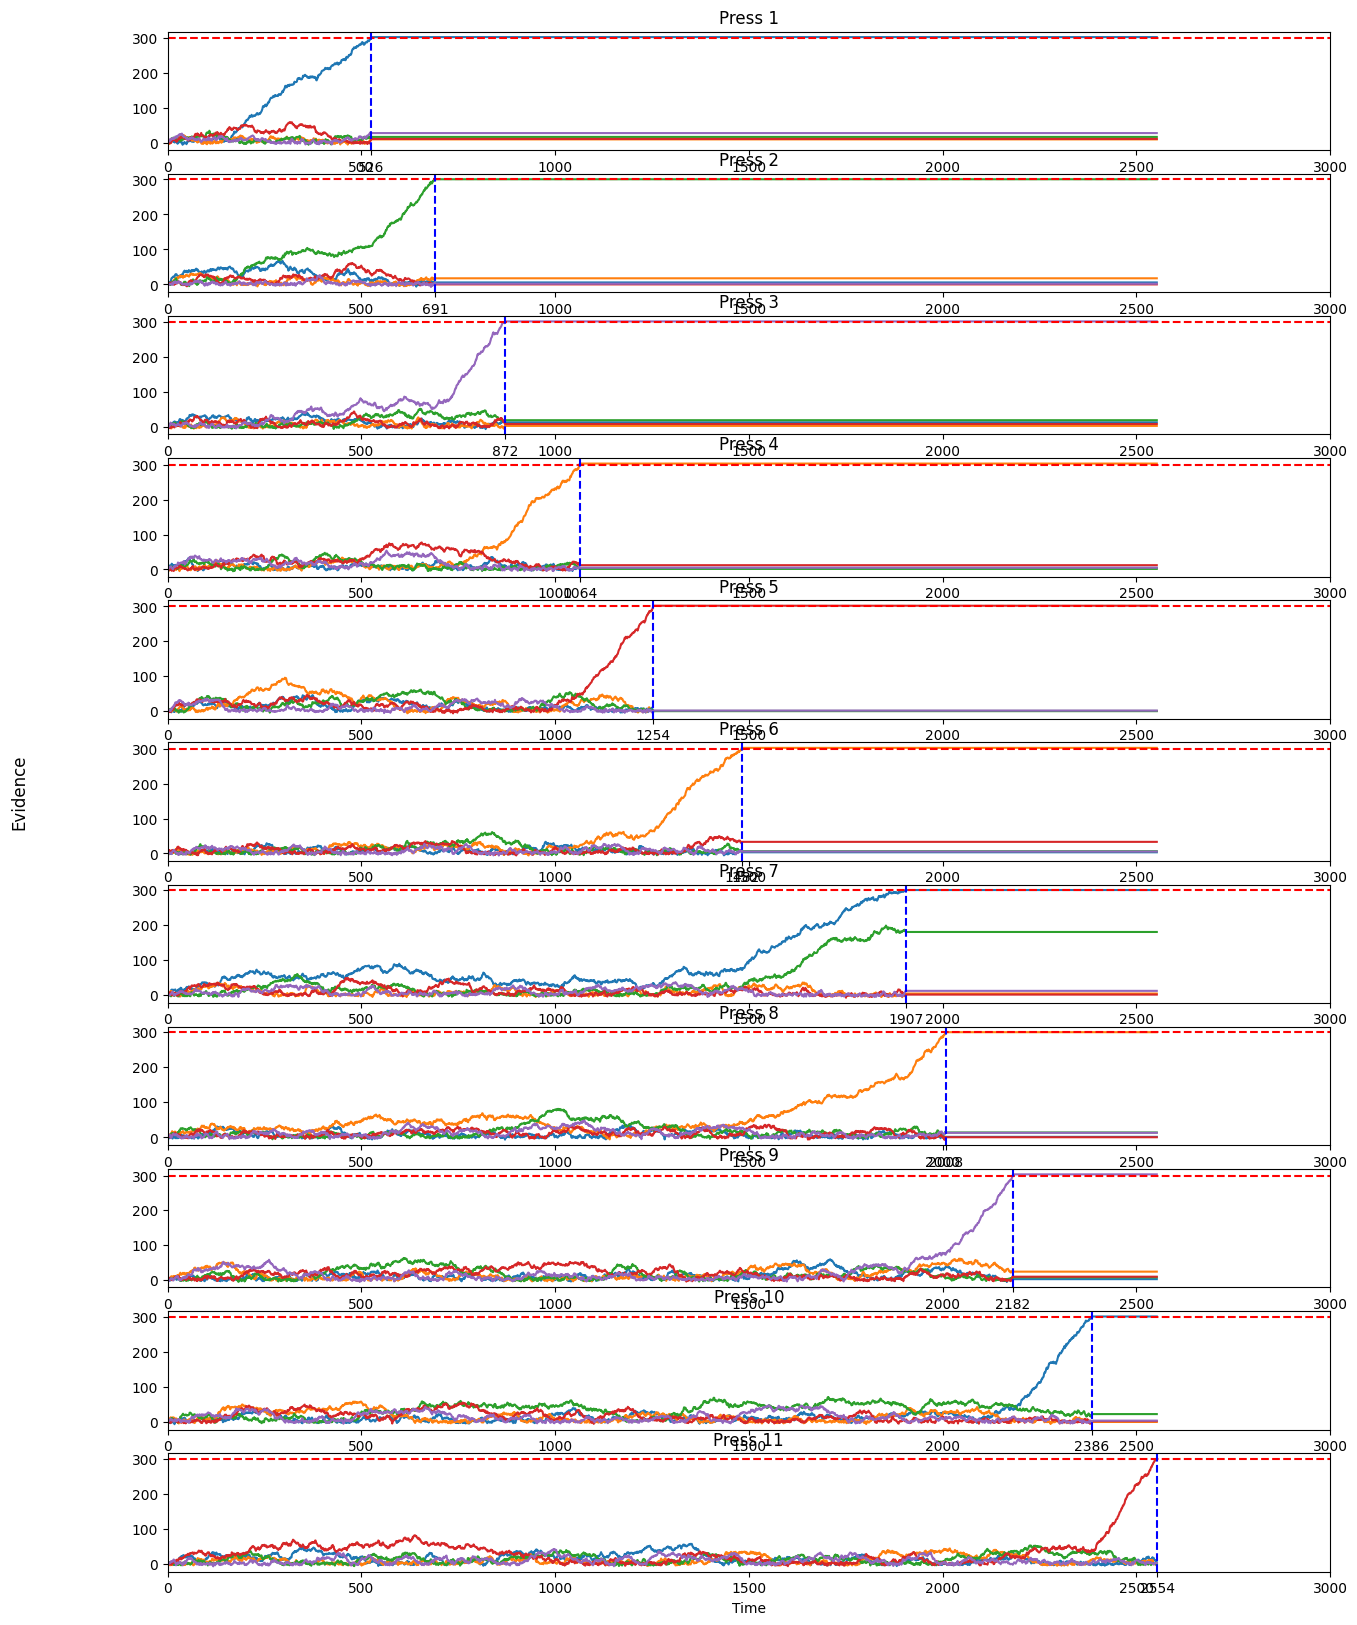

In [158]:
visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion = diffusion, threshold = threshold, visual_delay=150, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = alpha, beta = beta, window_size=3)
model.plot_simulations()
# model.simulate()
# model.plot_IPIs()

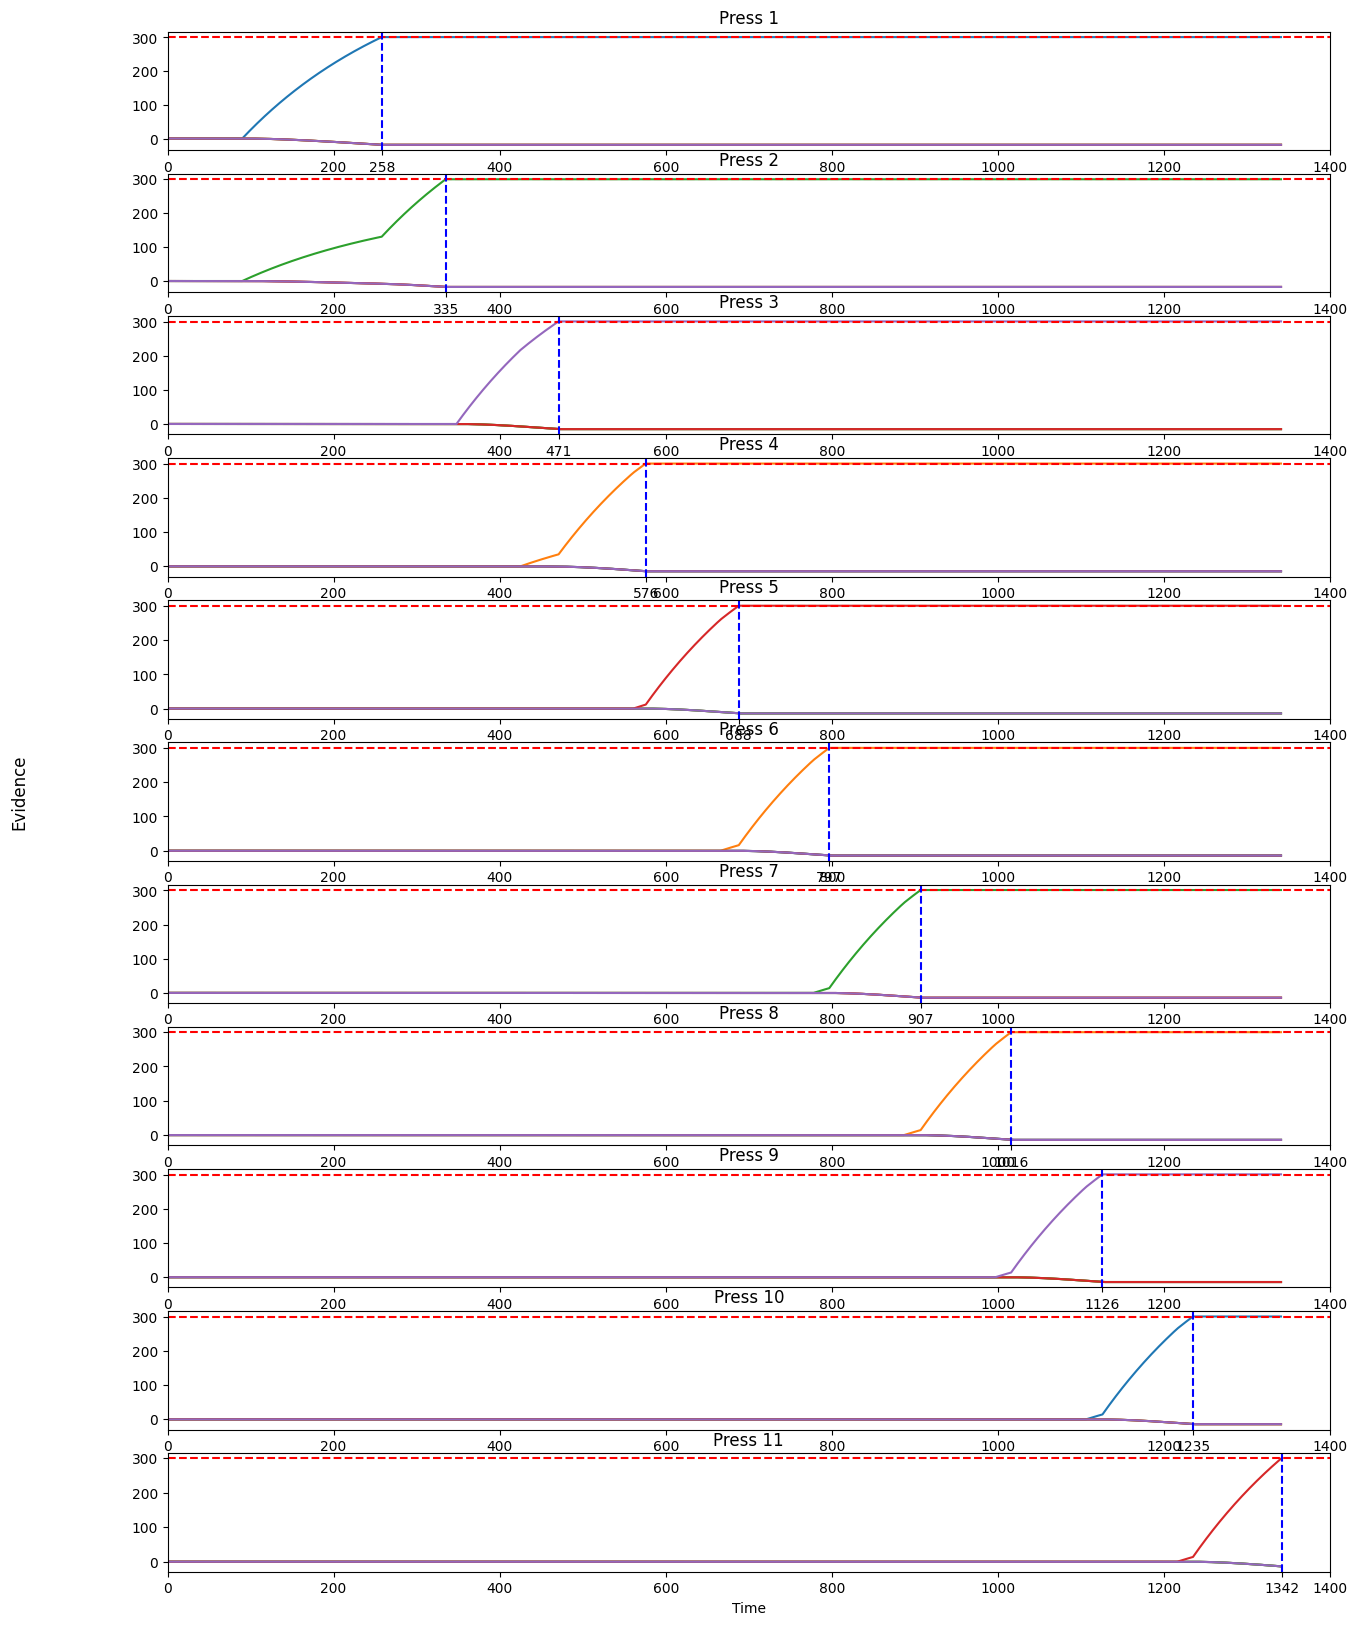

In [ ]:
visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion = 0, threshold = threshold, visual_delay=90, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = 0.995, window_size=2)
model.plot_simulations()
# model.simulate()
# model.plot_IPIs()

In [ ]:
visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

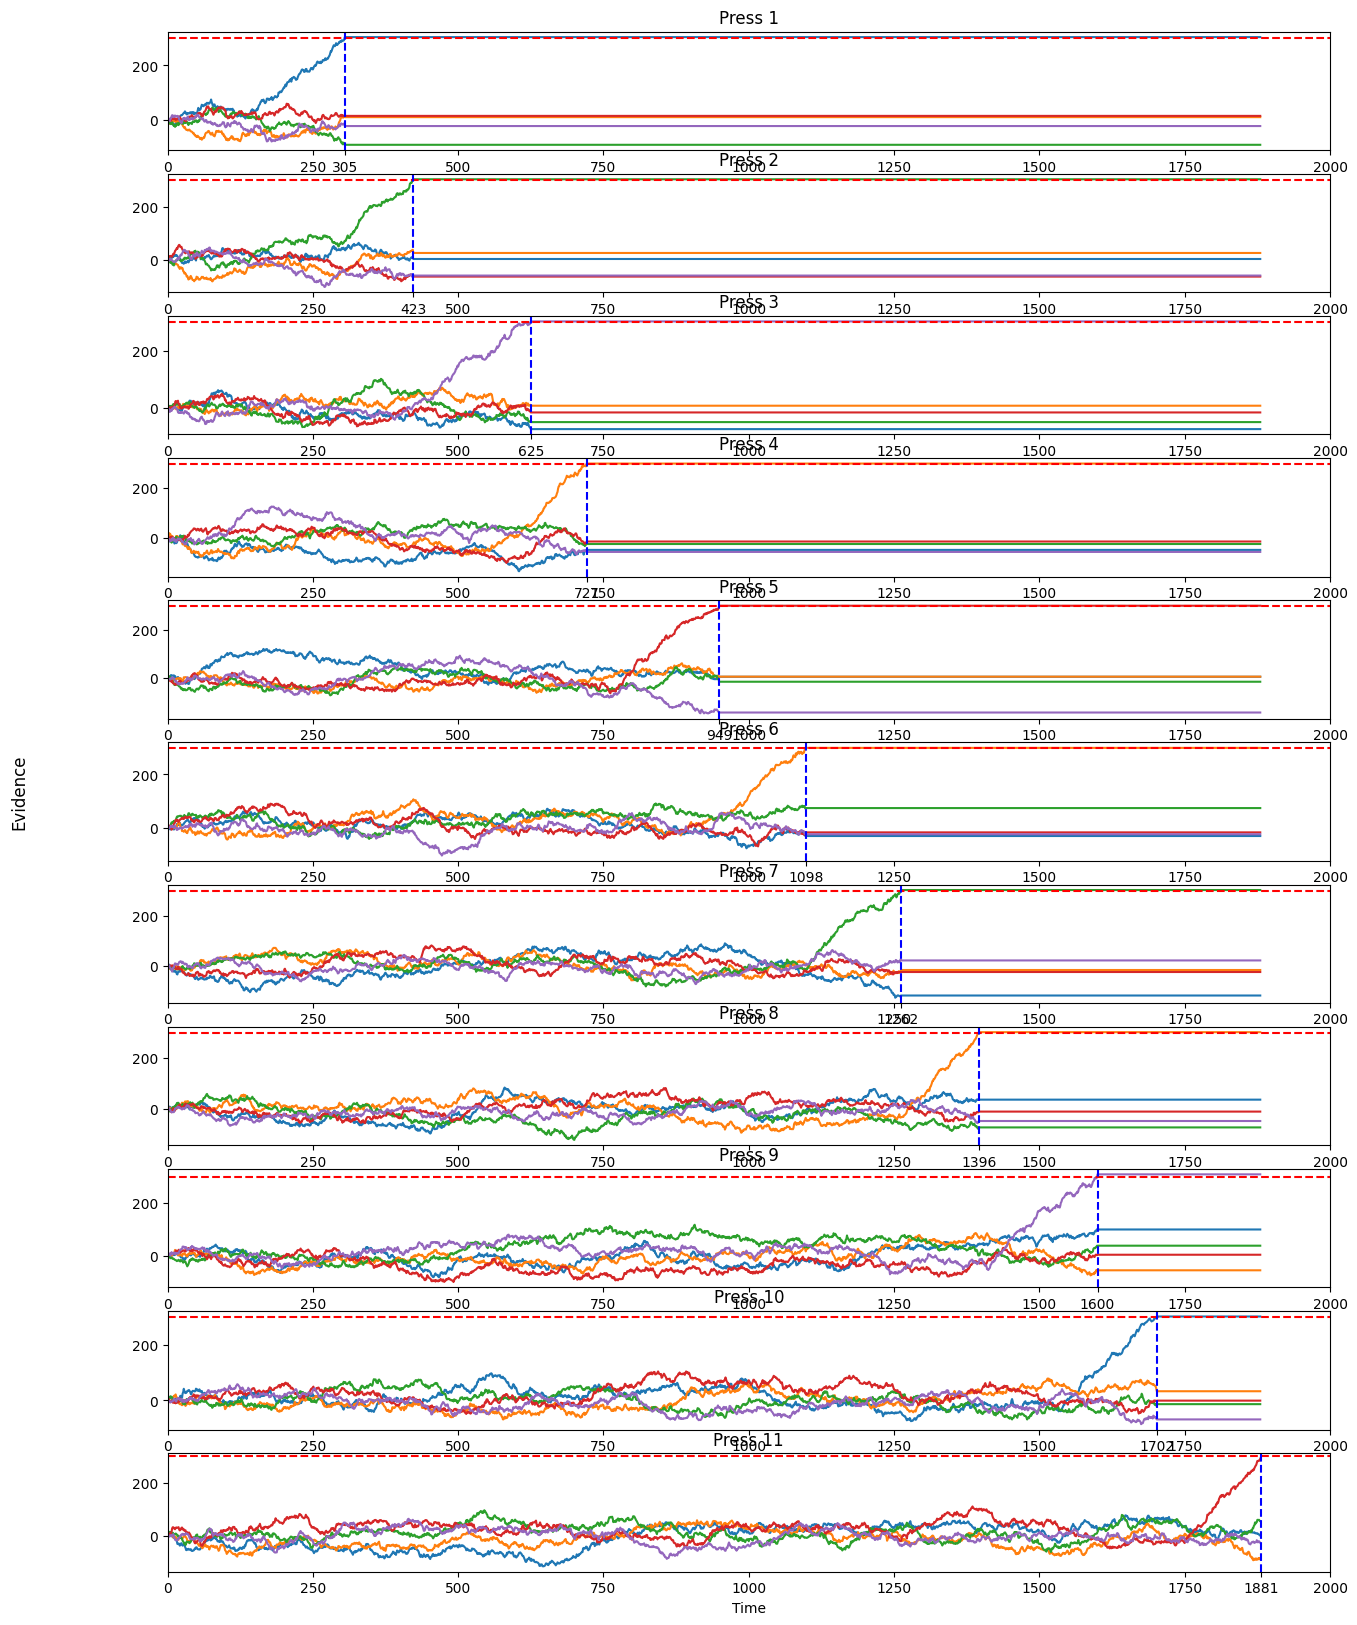

In [ ]:
model = DriftDiffusionModel_Optimzied(specific_seq, specific_seq, visual_drifts, memory_drifts, 
                                      diffusion, threshold, visual_delay=150, 
                                      planning_capacity=4, planning_param=2, seq_length=seq_length, alpha = 0.995, window_size=2)
model.plot_simulations()
# model.simulate()
# model.plot_IPIs()